# Selection llc + parcels data in a region

In [1]:
import os, shutil

import xarray as xr
import dask.dataframe as dd

#from rechunker import rechunk
# need version 0.3.3, see: https://github.com/pangeo-data/rechunker/issues/92

%matplotlib inline
from matplotlib import pyplot as plt

import mitequinox.plot as pl
import mitequinox.utils as ut
import mitequinox.parcels as pa

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.5383239.datarmor0/parcels-55081/libparcels_random_42d82917-af54-4d21-9965-ee6987ef7815.so


In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    w = cluster.scale(jobs=5)
    #
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

---

## define a region of interest


In [3]:
grd = ut.load_grd()

Start by plotting the bathymety

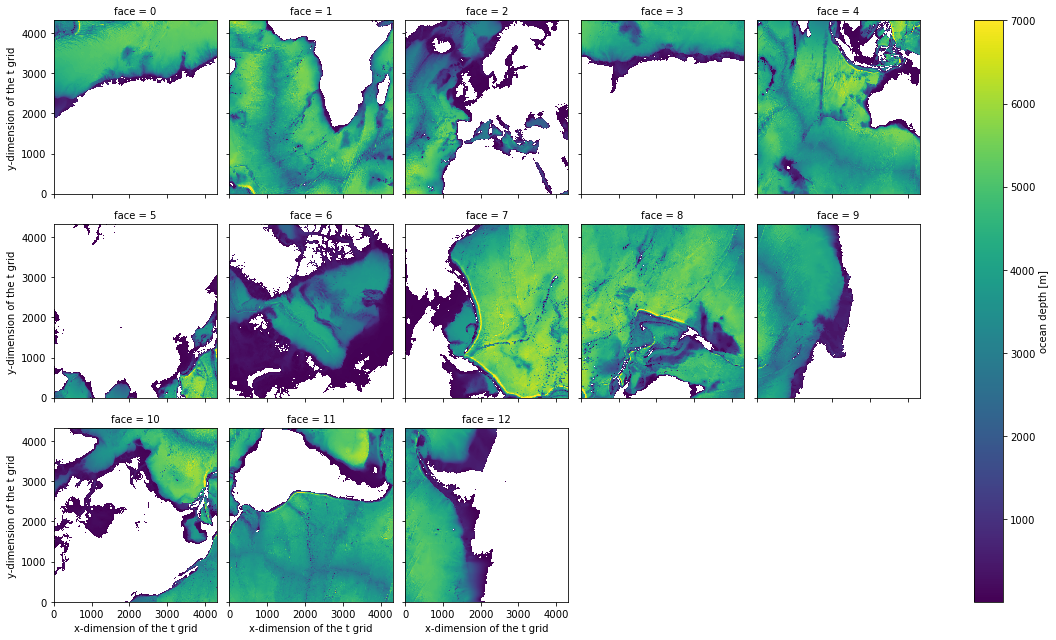

In [4]:
depth = grd.Depth.isel(i=slice(0,None,4), j=slice(0,None,4))
depth = depth.where(depth>0)

(depth
 .plot(col='face', col_wrap=5)
)

In [5]:
# select a region, here California
isel = dict(face=10, i=slice(2500, 3500), j=slice(0, 1000))

out_dir = os.path.join("/home/datawork-lops-osi/aponte/mit4320", "california")

# index chosen for the parcel data
parcels_index = "time"

In [6]:
# output archives
llc_zarr = os.path.join(out_dir, "llc.zarr")
parcels_name = "llc_parcels_"+parcels_index
parcels_path = os.path.join(out_dir, parcels_name)

# adjust dict
isel["i_g"] = isel["i"]
isel["j_g"] = isel["j"]

# create directory if not existing
os.makedirs(out_dir, exist_ok=True)

---
## load data llc, rechunk and store

if a region is too large, one my use the [rechunker library](https://rechunker.readthedocs.io/)

In [7]:
# 
#V = ['Eta']
V = ['SSU', 'SSV', 'Eta']
#V = ['SST', 'SSS']

ds = ut.load_data(V)
ds = ds.isel(**isel)
grd = grd.isel(**isel)
ds = xr.merge([ds, grd])

In [8]:
# define target chunks
chunks_new = dict(time=1024, i=128, j=128) # 512, 256, 256 may have been a better choice
chunks_new["i_g"] = chunks_new["i"]
chunks_new["j_g"] = chunks_new["j"]

ds = ds.chunk(chunks_new)

In [9]:
ds.to_zarr(llc_zarr, mode="w")

--- 
## load parcels data, subselect and store

In [25]:
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

# choose to select time indexed data for now
p = pa.parcels_output(root_dir+run_name, parquets=[parcels_index])
df = p[parcels_index]

df.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity
time,,,,,,,,,
2011-11-15,39000000,57.835732,-178.867081,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000001,58.429878,-178.871994,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000002,59.018066,-178.879623,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000003,59.600288,-178.890015,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000004,60.176525,-178.903275,0.0,0.0,0.0,0.0,0.0,0.0


Extract geographical extent from llc grid

In [20]:
llc_lon, llc_lat = grd.XC.compute(), grd.YC.compute()
extent = [float(llc_lon.min()), float(llc_lon.max()), 
          float(llc_lat.min()), float(llc_lat.max()),
         ]
extent

[-127.98958587646484,
 -107.17708587646484,
 28.357534408569336,
 43.80012130737305]

In [33]:
# extract relevant trajectory indices
_df = df[ (df.lon>extent[0])
        &(df.lon<extent[1])
        &(df.lat>extent[2])
        &(df.lat<extent[3])
       ]
traj = _df.drop_duplicates(subset=["trajectory"]).compute()["trajectory"]
df_selected = df[df.trajectory.isin(traj)]

pa.store_parquet(out_dir, df_selected, name=parcels_name, overwrite=True)

No reindexing
deleting existing archive: /home/datawork-lops-osi/aponte/mit4320/california/llc_parcels_time
create new archive: /home/datawork-lops-osi/aponte/mit4320/california/llc_parcels_time


'/home/datawork-lops-osi/aponte/mit4320/california/llc_parcels_time'

---

## make a quick plot for check

In [41]:
ds = xr.open_zarr(llc_zarr)
df = dd.read_parquet(parcels_path)

In [49]:
ds = ds.isel(time=0).persist()
_df = df.compute().iloc[::100,:]

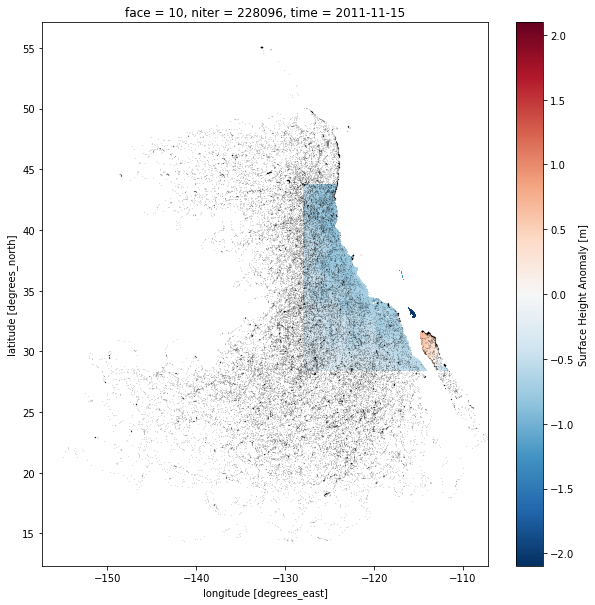

In [55]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

ax.plot(_df.lon,_df.lat,".", color="k", markersize=0.1)

ds.Eta.plot(x="XC", y="YC", ax=ax)

---
## close cluster

In [10]:
cluster.close()